<a href="https://colab.research.google.com/github/BaberFaisal/Code_Alpha_A-B-Testing-Analysis/blob/main/A_B_Testing_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [7]:
df = pd.read_csv("/content/ab_data.csv")

In [8]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0.0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0.0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0.0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0.0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1.0


In [9]:
df.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

In [18]:
# Step 1: Check the relationship between group and landing_page
group_landing_page_counts = df.groupby(['group', 'landing_page']).size().unstack()

In [19]:
# Step 2: Find inconsistencies where group doesn't match the expected landing page
inconsistent_rows = df[((df['group'] == 'control') & (df['landing_page'] != 'old_page')) |
                       ((df['group'] == 'treatment') & (df['landing_page'] != 'new_page'))]

In [20]:
# Step 3: Drop inconsistent rows
df_cleaned = df.drop(inconsistent_rows.index)

In [21]:
# Step 4: Check for duplicate user_ids
duplicate_users = df_cleaned[df_cleaned.duplicated('user_id', keep=False)]

In [22]:

# Drop duplicate user_ids (keep first occurrence)
df_cleaned = df_cleaned.drop_duplicates('user_id')

In [23]:
# Output results
group_landing_page_counts, inconsistent_rows.shape[0], duplicate_users.shape[0], df_cleaned.shape

(landing_page  new  new_page  old_page
 group                                
 control       NaN     139.0    9560.0
 treatment     1.0    9586.0     131.0,
 271,
 2,
 (19145, 5))

In [24]:
#Conversion Counts
conversions = df_cleaned.groupby('group')['converted'].agg(['sum', 'count'])

In [26]:
successes = conversions['sum'].values
n_obs = conversions['count'].values

z_stat, p_value = proportions_ztest(count=successes, nobs=n_obs, alternative='larger')


In [34]:
print(f"Control Conversion Rate: {conversion_rates.iloc[0]:.4f}")


Control Conversion Rate: 0.1211


In [36]:
print(f"Treatment Conversion Rate: {conversion_rates.iloc[1]:.4f}")


Treatment Conversion Rate: 0.1238


In [37]:

print(f"Z-statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

Z-statistic: -0.5718, p-value: 0.7163


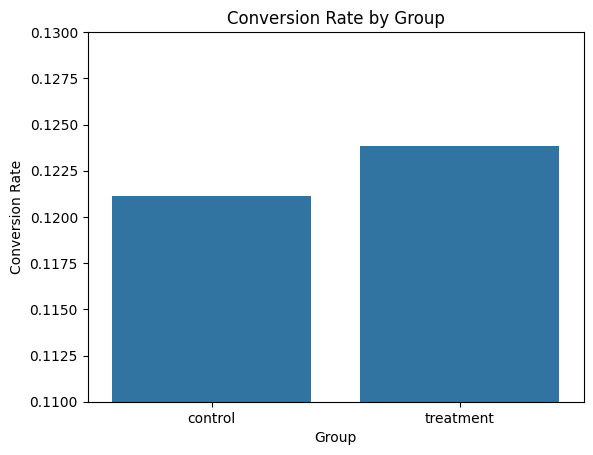

In [40]:
# Plot conversion rates
sns.barplot(x=conversions.index, y=conversion_rates.values)
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.ylim(0.11, 0.13)
plt.show()


In [42]:
from statsmodels.stats.power import NormalIndPower

# Power analysis
effect_size = 0.1235 - 0.12
baseline = 0.12
power_analysis = NormalIndPower()
required_n = power_analysis.solve_power(
    effect_size=effect_size / baseline,  # standardized
    power=0.8,
    alpha=0.05,
    ratio=1.0,
    alternative='larger'
)
print(f"Required sample size per group: {int(required_n)}")


Required sample size per group: 14535


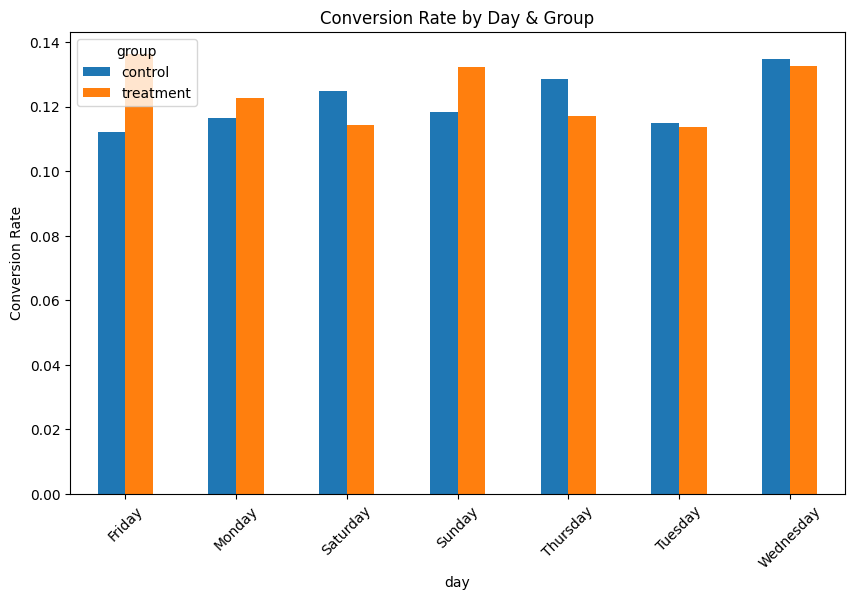

In [44]:
# Example: Extract day of week from timestamp
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])
df_cleaned['day'] = df_cleaned['timestamp'].dt.day_name()

# Compare conversion by group and day
group_day = df_cleaned.groupby(['group', 'day'])['converted'].mean().unstack()

# Plot
group_day.T.plot(kind='bar', figsize=(10,6))
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Day & Group')
plt.xticks(rotation=45)
plt.show()
